In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-eccc8c9o
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-eccc8c9o
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101078 sha256=38592318094e5b59f3fb59f81091a40d79277e9ba7aee43b8e95df6eebb0d887
  Stored in directory: /tmp/pip-ephem-wheel-cache-1z7nu_5a/wheels/83/b3/99/125cd08d3e8224b434b1b4badd6f8b2651e0251b7e8f983e60
Successfully built keras-contrib


In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

In [ ]:
!nvidia-smi

Mon Apr 24 02:56:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)

	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

In [ ]:
disc_ = define_discriminator((128, 128,3))
disc_.summary()

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 instance_normalization (Ins  (None, 32, 32, 128)      256       
 tanceNormalization)                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                             

In [ ]:
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g


In [ ]:
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [ ]:
define_generator((128, 128, 3)).summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 instance_normalization_4 (Inst  (None, 128, 128, 64  128        ['conv2d_6[0][0]']               
 anceNormalization)             )                                                           

In [ ]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):

	g_model_1.trainable = True
	# mark discriminator and second generator as non-trainable
	d_model.trainable = False
	g_model_2.trainable = False

	# adversarial loss
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity loss
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# cycle loss - forward
	output_f = g_model_2(gen1_out)
	# cycle loss - backward
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)

	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])

    # define the optimizer
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'],
               loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model


In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
# select a batch of random samples, returns images and target
#Remember that for real images the label (y) is 1.
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
#Remember that for fake images the label (y) is 0.
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake images
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# periodically save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = '/content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = '/content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# periodically generate images using the save model and plot input and output images
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '/content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust_Image/%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()


def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
dA_losses1= []
dA_losses2= []

dB_losses1 = []
dB_losses2 = []

g_losses1 = []
g_losses2 = []

In [ ]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
	# define properties of the training run
	n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fake images
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs

	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples from each domain (A and B)
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples using both B to A and A to B generators.
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)

		# update generator B->A via the composite model
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

        # update generator A->B via the composite model
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

		# save the losses
		dA_losses1.append(dA_loss1)
		dA_losses2.append(dA_loss2)

		dB_losses1.append(dB_loss1)
		dB_losses2.append(dB_loss2)

		g_losses1.append(g_loss1)
		g_losses2.append(g_loss2)

		with open('/content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/dA_dB_g_losses.npy', 'wb') as f:
				np.savez(f, dA_losses1, dA_losses2, dB_losses1, dB_losses2, g_losses1, g_losses2)


		print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1, dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))

		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
			save_models(i, g_model_AtoB, g_model_BtoA)

		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
            # #If batch size (total images)=100, model will be saved after
            #every 75th iteration x 5 = 375 iterations.
			save_models(i, g_model_AtoB, g_model_BtoA)

In [ ]:
import os
len(os.listdir("/content/drive/My Drive/Wheat_Disease/wheat_leaf/stripe_rust/"))

208

In [ ]:
(os.listdir("/content/drive/My Drive/Wheat_Disease/wheat_leaf/"))

['Healthy', 'stripe_rust', 'septoria']

100%|██████████| 102/102 [00:40<00:00,  2.50it/s]


Loaded dataA:  (102, 128, 128, 3)


100%|██████████| 208/208 [01:18<00:00,  2.66it/s]


Loaded dataB:  (208, 128, 128, 3)


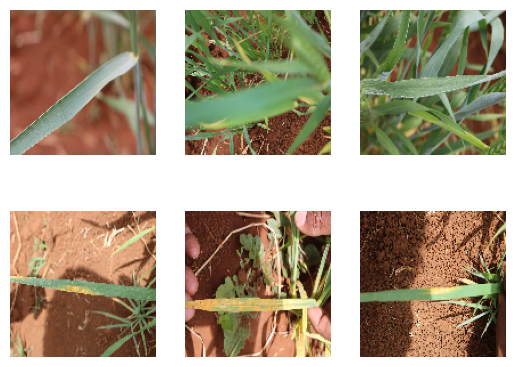

Loaded (102, 128, 128, 3) (208, 128, 128, 3)


In [ ]:
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

# load all images in a directory into memory
def load_images(path_arr, size=(128,128)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for path in path_arr:
		for filename in tqdm(listdir(path)):
			# load and resize the image
			pixels = load_img(path + filename, target_size=size)
			# convert to numpy array
			pixels = img_to_array(pixels)
			# store
			data_list.append(pixels)
	return asarray(data_list)


# dataset path
pathA = ["/content/drive/My Drive/Wheat_Disease/wheat_leaf/Healthy/"]


# load dataset A - Monet paintings
dataA_all = load_images(pathA)
print('Loaded dataA: ', dataA_all.shape)

from sklearn.utils import resample

pathB = ["/content/drive/My Drive/Wheat_Disease/wheat_leaf/stripe_rust/"]


dataB_all = load_images(pathB)
print('Loaded dataB: ', dataB_all.shape)

n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA_all[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB_all[i].astype('uint8'))
plt.show()


# load image data
data = [dataA_all, dataB_all]

print('Loaded', data[0].shape, data[1].shape)

def preprocess_data(data):
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

In [ ]:
# from cycleGAN_model import define_generator, define_discriminator, define_composite_model, train
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

from datetime import datetime
start1 = datetime.now()
# train models

epochs = 5000
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=epochs)

stop1 = datetime.now()
#Execution time of the model
execution_time = stop1-start1
print("Execution time: ", execution_time)

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 759ms/step
Iteration>1, dA[1.382,4.902] dB[1.106,5.118] g[17.040,17.804]
1/1 [==============================] - 0s 22ms/step
Iteration>2, dA[9.828,7.468] dB[13.316,8.210] g[31.198,27.936]
1/1 [==============================] - 0s 21ms/step
Iteration>3, dA[13.316,17.360] dB[18.427,16.484] g[51.430,26.108]
1/1 [==============================] - 0s 21ms/step
Iteration>4, dA[20.466,13.377] dB[10.752,10.493] g[51.861,117.575]
1/1 [==============================] - 0s 21ms/step
Iteration>5, dA[17.999,14.148] dB[22.900,3.797] g[42.203,42.238]
1/1 [==============================] - 0s 22ms/step
Iteration>6, dA[2.219,7.648] dB[4.765,3.787] g[20.516,19.165]
1/1 [==============================] - 0s 20ms/step
Iteration>7, dA[3.286,1.809] dB[2.056,2.415] g[19.184,20.487]
1/1 [==============================] - 0s 21ms/step
Iteration>8, dA[2.004,1.202] dB[1.506,1.441] g[16.334,18.095]
1/1 [==============================] - 0s 23ms/step
Iteration>9, dA[0.959,

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_000102.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_000102.h5
1/1 [==============================] - 0s 21ms/step
Iteration>103, dA[0.552,0.184] dB[0.330,1.004] g[6.934,8.179]
1/1 [==============================] - 0s 22ms/step
Iteration>104, dA[0.381,0.619] dB[0.389,0.156] g[7.159,7.073]
1/1 [==============================] - 0s 21ms/step
Iteration>105, dA[0.539,0.620] dB[0.532,1.098] g[6.670,7.349]
1/1 [==============================] - 0s 21ms/step
Iteration>106, dA[0.251,0.234] dB[0.892,0.581] g[6.146,5.984]
1/1 [==============================] - 0s 25ms/step
Iteration>107, dA[0.242,0.207] dB[0.542,0.110] g[7.306,8.214]
1/1 [==============================] - 0s 23ms/step
Iteration>108, dA[0.373,0.200] dB[0.143,0.182] g[5.200,5.962]
1/1 [==============================] - 0s 25ms/step
Iteration>109, dA[0.187,0.441] dB[0.122,0.247] g[6.331,7.597]
1/1 [=========

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_000204.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_000204.h5
1/1 [==============================] - 0s 21ms/step
Iteration>205, dA[0.191,0.500] dB[0.135,0.355] g[4.473,4.950]
1/1 [==============================] - 0s 21ms/step
Iteration>206, dA[0.169,0.069] dB[0.167,0.128] g[6.332,6.436]
1/1 [==============================] - 0s 20ms/step
Iteration>207, dA[0.339,0.565] dB[0.196,0.417] g[5.323,5.885]
1/1 [==============================] - 0s 26ms/step
Iteration>208, dA[0.225,0.105] dB[0.362,0.519] g[4.812,5.278]
1/1 [==============================] - 0s 21ms/step
Iteration>209, dA[0.342,0.253] dB[0.642,0.324] g[6.502,6.444]
1/1 [==============================] - 0s 21ms/step
Iteration>210, dA[0.292,0.112] dB[0.320,0.245] g[6.989,7.961]
1/1 [==============================] - 0s 24ms/step
Iteration>211, dA[0.188,0.200] dB[0.272,0.652] g[6.109,5.922]
1/1 [=========

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_000306.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_000306.h5
1/1 [==============================] - 0s 20ms/step
Iteration>307, dA[0.090,0.156] dB[0.272,0.287] g[5.459,5.451]
1/1 [==============================] - 0s 23ms/step
Iteration>308, dA[0.069,0.143] dB[0.324,0.293] g[4.797,5.027]
1/1 [==============================] - 0s 22ms/step
Iteration>309, dA[0.433,0.571] dB[0.471,0.201] g[5.213,4.953]
1/1 [==============================] - 0s 25ms/step
Iteration>310, dA[0.157,0.138] dB[0.218,0.371] g[4.638,5.548]
1/1 [==============================] - 0s 23ms/step
Iteration>311, dA[0.305,0.380] dB[0.782,0.550] g[5.266,5.629]
1/1 [==============================] - 0s 20ms/step
Iteration>312, dA[0.123,0.074] dB[0.222,0.449] g[5.045,5.473]
1/1 [==============================] - 0s 20ms/step
Iteration>313, dA[0.117,0.185] dB[0.297,0.530] g[6.998,6.896]
1/1 [=========

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_000408.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_000408.h5
1/1 [==============================] - 0s 23ms/step
Iteration>409, dA[0.321,0.074] dB[0.333,0.156] g[4.457,5.689]
1/1 [==============================] - 0s 30ms/step
Iteration>410, dA[0.128,0.075] dB[0.083,0.157] g[4.208,4.224]
1/1 [==============================] - 0s 24ms/step
Iteration>411, dA[0.085,0.073] dB[0.247,0.085] g[6.226,6.077]
1/1 [==============================] - 0s 25ms/step
Iteration>412, dA[0.040,0.190] dB[0.094,0.405] g[5.450,5.339]
1/1 [==============================] - 0s 25ms/step
Iteration>413, dA[0.217,0.051] dB[0.096,0.070] g[4.582,5.147]
1/1 [==============================] - 0s 24ms/step
Iteration>414, dA[0.094,0.062] dB[0.368,0.319] g[7.942,8.632]
1/1 [==============================] - 0s 24ms/step
Iteration>415, dA[0.034,0.159] dB[0.106,0.241] g[6.074,6.194]
1/1 [=========

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_000510.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_000510.h5


>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_000510.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_000510.h5
1/1 [==============================] - 0s 21ms/step
Iteration>511, dA[0.034,0.068] dB[0.103,0.363] g[5.046,5.688]
1/1 [==============================] - 0s 22ms/step
Iteration>512, dA[0.081,0.043] dB[0.371,0.110] g[4.962,4.738]
1/1 [==============================] - 0s 22ms/step
Iteration>513, dA[0.052,0.095] dB[0.142,0.503] g[6.505,7.163]
1/1 [==============================] - 0s 22ms/step
Iteration>514, dA[0.034,0.288] dB[0.117,0.181] g[11.370,9.550]
1/1 [==============================] - 0s 21ms/step
Iteration>515, dA[0.373,0.111] dB[0.458,0.163] g[7.689,7.697]
1/1 [==============================] - 0s 24ms/step
Iteration>516, dA[0.205,0.083] dB[0.312,0.159] g[6.479,6.767]
1/1 [==============================] - 0s 21ms/step
Iteration>517, dA[0.052,0.033] dB[0.160,0.167] g[5.192,4.595]
1/1 [========

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_000612.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_000612.h5
1/1 [==============================] - 0s 21ms/step
Iteration>613, dA[0.175,0.095] dB[0.222,0.089] g[8.169,6.481]
1/1 [==============================] - 0s 22ms/step
Iteration>614, dA[0.032,0.125] dB[0.096,0.127] g[6.870,5.474]
1/1 [==============================] - 0s 21ms/step
Iteration>615, dA[0.391,0.088] dB[0.200,0.268] g[10.058,12.319]
1/1 [==============================] - 0s 21ms/step
Iteration>616, dA[0.151,0.355] dB[0.233,0.167] g[7.377,8.073]
1/1 [==============================] - 0s 22ms/step
Iteration>617, dA[0.123,0.178] dB[0.100,0.113] g[5.288,4.811]
1/1 [==============================] - 0s 21ms/step
Iteration>618, dA[0.270,0.096] dB[0.074,0.113] g[6.952,7.181]
1/1 [==============================] - 0s 21ms/step
Iteration>619, dA[0.168,0.199] dB[0.046,0.132] g[5.384,5.781]
1/1 [=======

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_000714.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_000714.h5
1/1 [==============================] - 0s 22ms/step
Iteration>715, dA[0.099,0.107] dB[0.119,0.084] g[6.364,5.506]
1/1 [==============================] - 0s 24ms/step
Iteration>716, dA[0.180,0.114] dB[0.057,0.087] g[17.735,15.345]
1/1 [==============================] - 0s 20ms/step
Iteration>717, dA[0.081,0.473] dB[0.048,0.192] g[5.103,5.519]
1/1 [==============================] - 0s 27ms/step
Iteration>718, dA[0.232,0.081] dB[0.095,0.198] g[4.278,5.031]
1/1 [==============================] - 0s 23ms/step
Iteration>719, dA[0.149,0.044] dB[0.124,0.071] g[5.971,5.363]
1/1 [==============================] - 0s 24ms/step
Iteration>720, dA[0.032,0.049] dB[0.088,0.045] g[4.857,3.802]
1/1 [==============================] - 0s 20ms/step
Iteration>721, dA[0.040,0.082] dB[0.035,0.031] g[4.938,5.092]
1/1 [=======

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_000816.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_000816.h5
1/1 [==============================] - 0s 21ms/step
Iteration>817, dA[0.071,0.073] dB[0.036,0.095] g[5.308,6.217]
1/1 [==============================] - 0s 23ms/step
Iteration>818, dA[0.195,0.062] dB[0.206,0.127] g[4.000,4.419]
1/1 [==============================] - 0s 21ms/step
Iteration>819, dA[0.057,0.043] dB[0.081,0.092] g[4.467,4.675]
1/1 [==============================] - 0s 20ms/step
Iteration>820, dA[0.072,0.185] dB[0.020,0.213] g[4.293,4.377]
1/1 [==============================] - 0s 21ms/step
Iteration>821, dA[0.179,0.035] dB[0.347,0.391] g[5.241,5.824]
1/1 [==============================] - 0s 21ms/step
Iteration>822, dA[0.236,0.532] dB[0.098,0.071] g[3.933,3.904]
1/1 [==============================] - 0s 20ms/step
Iteration>823, dA[0.080,0.083] dB[0.378,0.127] g[4.673,4.701]
1/1 [=========

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_000918.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_000918.h5
1/1 [==============================] - 0s 24ms/step
Iteration>919, dA[0.252,0.441] dB[0.083,0.287] g[4.229,4.735]
1/1 [==============================] - 0s 24ms/step
Iteration>920, dA[0.203,0.039] dB[0.794,0.111] g[6.829,6.394]
1/1 [==============================] - 0s 23ms/step
Iteration>921, dA[0.119,0.093] dB[0.105,0.041] g[9.279,9.722]
1/1 [==============================] - 0s 24ms/step
Iteration>922, dA[0.063,0.074] dB[0.286,0.115] g[4.436,3.869]
1/1 [==============================] - 0s 25ms/step
Iteration>923, dA[0.033,0.029] dB[0.072,0.068] g[5.684,5.992]
1/1 [==============================] - 0s 23ms/step
Iteration>924, dA[0.035,0.027] dB[0.324,0.107] g[6.442,5.275]
1/1 [==============================] - 0s 25ms/step
Iteration>925, dA[0.071,0.036] dB[0.287,0.225] g[4.065,4.269]
1/1 [=========

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_001020.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_001020.h5


>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_001020.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_001020.h5
1/1 [==============================] - 0s 20ms/step
Iteration>1021, dA[0.027,0.168] dB[0.307,0.518] g[5.273,6.034]
1/1 [==============================] - 0s 20ms/step
Iteration>1022, dA[0.119,0.052] dB[0.061,0.066] g[6.269,8.374]
1/1 [==============================] - 0s 20ms/step
Iteration>1023, dA[0.096,0.211] dB[0.198,0.041] g[4.539,4.312]
1/1 [==============================] - 0s 20ms/step
Iteration>1024, dA[0.111,0.069] dB[0.051,0.165] g[4.689,4.895]
1/1 [==============================] - 0s 23ms/step
Iteration>1025, dA[0.298,0.019] dB[0.083,0.089] g[3.971,5.794]
1/1 [==============================] - 0s 23ms/step
Iteration>1026, dA[0.095,0.027] dB[0.015,0.061] g[5.190,5.233]
1/1 [==============================] - 0s 20ms/step
Iteration>1027, dA[0.207,0.050] dB[0.213,0.165] g[3.982,4.594]
1/1 [==

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_001122.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_001122.h5
1/1 [==============================] - 0s 21ms/step
Iteration>1123, dA[0.259,0.227] dB[0.184,0.045] g[5.257,5.871]
1/1 [==============================] - 0s 22ms/step
Iteration>1124, dA[0.060,0.029] dB[0.020,0.101] g[4.989,5.027]
1/1 [==============================] - 0s 20ms/step
Iteration>1125, dA[0.104,0.092] dB[0.354,0.075] g[4.788,3.904]
1/1 [==============================] - 0s 21ms/step
Iteration>1126, dA[0.024,0.044] dB[0.048,0.183] g[5.121,5.349]
1/1 [==============================] - 0s 22ms/step
Iteration>1127, dA[0.100,0.067] dB[0.123,0.105] g[4.308,4.492]
1/1 [==============================] - 0s 21ms/step
Iteration>1128, dA[0.021,0.020] dB[0.040,0.142] g[4.019,4.738]
1/1 [==============================] - 0s 27ms/step
Iteration>1129, dA[0.015,0.021] dB[0.045,0.076] g[4.538,4.445]
1/1 [==

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_001224.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_001224.h5
1/1 [==============================] - 0s 21ms/step
Iteration>1225, dA[0.046,0.016] dB[0.026,0.116] g[4.679,5.419]
1/1 [==============================] - 0s 20ms/step
Iteration>1226, dA[0.024,0.028] dB[0.268,0.395] g[4.732,5.388]
1/1 [==============================] - 0s 21ms/step
Iteration>1227, dA[0.047,0.025] dB[0.082,0.023] g[7.193,9.370]
1/1 [==============================] - 0s 21ms/step
Iteration>1228, dA[0.186,0.066] dB[0.128,0.052] g[5.224,6.796]
1/1 [==============================] - 0s 23ms/step
Iteration>1229, dA[0.029,0.034] dB[0.053,0.026] g[4.342,5.506]
1/1 [==============================] - 0s 21ms/step
Iteration>1230, dA[0.082,0.044] dB[0.068,0.053] g[4.692,5.690]
1/1 [==============================] - 0s 20ms/step
Iteration>1231, dA[0.058,0.023] dB[0.131,0.018] g[8.753,8.969]
1/1 [==

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_001326.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_001326.h5
1/1 [==============================] - 0s 25ms/step
Iteration>1327, dA[0.043,0.015] dB[0.124,0.261] g[5.793,7.271]
1/1 [==============================] - 0s 25ms/step
Iteration>1328, dA[0.045,0.089] dB[0.071,0.286] g[6.094,6.460]
1/1 [==============================] - 0s 22ms/step
Iteration>1329, dA[0.107,0.078] dB[0.054,0.020] g[4.684,4.340]
1/1 [==============================] - 0s 22ms/step
Iteration>1330, dA[0.039,0.029] dB[0.150,0.037] g[7.199,7.366]
1/1 [==============================] - 0s 20ms/step
Iteration>1331, dA[0.261,0.030] dB[0.039,0.040] g[4.030,5.161]
1/1 [==============================] - 0s 22ms/step
Iteration>1332, dA[0.114,0.012] dB[0.015,0.456] g[4.741,5.040]
1/1 [==============================] - 0s 21ms/step
Iteration>1333, dA[0.042,0.013] dB[0.042,0.021] g[5.533,6.330]
1/1 [==

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_001428.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_001428.h5
1/1 [==============================] - 0s 23ms/step
Iteration>1429, dA[0.093,0.106] dB[0.059,0.194] g[6.699,8.013]
1/1 [==============================] - 0s 25ms/step
Iteration>1430, dA[0.122,0.066] dB[0.214,0.096] g[8.917,10.400]
1/1 [==============================] - 0s 25ms/step
Iteration>1431, dA[0.380,0.182] dB[0.055,0.053] g[4.803,5.434]
1/1 [==============================] - 0s 25ms/step
Iteration>1432, dA[0.048,0.060] dB[0.031,0.078] g[5.786,5.940]
1/1 [==============================] - 0s 23ms/step
Iteration>1433, dA[0.026,0.026] dB[0.021,0.088] g[5.666,5.465]
1/1 [==============================] - 0s 26ms/step
Iteration>1434, dA[0.016,0.291] dB[0.243,0.036] g[5.358,4.746]
1/1 [==============================] - 0s 25ms/step
Iteration>1435, dA[0.108,0.020] dB[0.074,0.192] g[5.750,6.108]
1/1 [=

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_001530.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_001530.h5


>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_001530.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_001530.h5
1/1 [==============================] - 0s 22ms/step
Iteration>1531, dA[0.173,0.236] dB[0.168,0.030] g[5.055,4.614]
1/1 [==============================] - 0s 21ms/step
Iteration>1532, dA[0.149,0.081] dB[0.107,0.352] g[5.044,4.318]
1/1 [==============================] - 0s 20ms/step
Iteration>1533, dA[0.059,0.104] dB[0.257,0.068] g[4.882,4.407]
1/1 [==============================] - 0s 24ms/step
Iteration>1534, dA[0.028,0.080] dB[0.040,0.078] g[9.394,10.400]
1/1 [==============================] - 0s 21ms/step
Iteration>1535, dA[0.118,0.020] dB[0.269,0.104] g[8.348,10.042]
1/1 [==============================] - 0s 27ms/step
Iteration>1536, dA[0.127,0.205] dB[0.083,0.235] g[5.424,6.211]
1/1 [==============================] - 0s 25ms/step
Iteration>1537, dA[0.080,0.077] dB[0.112,0.029] g[7.018,6.943]
1/1 [

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_001632.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_001632.h5
1/1 [==============================] - 0s 24ms/step
Iteration>1633, dA[0.018,0.013] dB[0.023,0.034] g[5.112,5.852]
1/1 [==============================] - 0s 21ms/step
Iteration>1634, dA[0.342,0.308] dB[0.125,0.035] g[4.915,4.953]
1/1 [==============================] - 0s 24ms/step
Iteration>1635, dA[0.025,0.045] dB[0.014,0.031] g[5.388,5.126]
1/1 [==============================] - 0s 26ms/step
Iteration>1636, dA[0.154,0.107] dB[0.318,0.116] g[5.969,5.408]
1/1 [==============================] - 0s 22ms/step
Iteration>1637, dA[0.099,0.315] dB[0.027,0.196] g[6.182,5.466]
1/1 [==============================] - 0s 21ms/step
Iteration>1638, dA[0.179,0.024] dB[0.079,0.015] g[5.580,5.569]
1/1 [==============================] - 0s 26ms/step
Iteration>1639, dA[0.014,0.030] dB[0.055,0.024] g[7.991,8.524]
1/1 [==

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_001734.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_001734.h5
1/1 [==============================] - 0s 24ms/step
Iteration>1735, dA[0.047,0.031] dB[0.098,0.008] g[10.774,11.330]
1/1 [==============================] - 0s 21ms/step
Iteration>1736, dA[0.062,0.155] dB[0.023,0.058] g[7.029,7.463]
1/1 [==============================] - 0s 21ms/step
Iteration>1737, dA[0.115,0.010] dB[0.018,0.020] g[7.739,8.465]
1/1 [==============================] - 0s 21ms/step
Iteration>1738, dA[0.486,0.130] dB[0.076,0.214] g[3.947,4.270]
1/1 [==============================] - 0s 20ms/step
Iteration>1739, dA[0.102,0.106] dB[0.035,0.016] g[4.854,3.972]
1/1 [==============================] - 0s 21ms/step
Iteration>1740, dA[0.096,0.493] dB[0.073,0.025] g[5.586,4.506]
1/1 [==============================] - 0s 22ms/step
Iteration>1741, dA[0.242,0.162] dB[0.023,0.105] g[4.316,4.443]
1/1 [

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_001836.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_001836.h5
1/1 [==============================] - 0s 22ms/step
Iteration>1837, dA[0.258,0.176] dB[0.071,0.026] g[4.299,4.732]
1/1 [==============================] - 0s 21ms/step
Iteration>1838, dA[0.058,0.088] dB[0.144,0.031] g[4.388,4.025]
1/1 [==============================] - 0s 21ms/step
Iteration>1839, dA[0.030,0.042] dB[0.019,0.091] g[3.574,4.325]
1/1 [==============================] - 0s 21ms/step
Iteration>1840, dA[0.152,0.028] dB[0.085,0.151] g[4.275,4.683]
1/1 [==============================] - 0s 21ms/step
Iteration>1841, dA[0.082,0.052] dB[0.193,0.038] g[3.562,3.076]
1/1 [==============================] - 0s 21ms/step
Iteration>1842, dA[0.045,0.169] dB[0.047,0.195] g[2.897,3.089]
1/1 [==============================] - 0s 21ms/step
Iteration>1843, dA[0.025,0.189] dB[0.013,0.038] g[7.158,7.668]
1/1 [==

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_001938.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_001938.h5
1/1 [==============================] - 0s 21ms/step
Iteration>1939, dA[0.157,0.090] dB[0.098,0.207] g[4.202,4.013]
1/1 [==============================] - 0s 21ms/step
Iteration>1940, dA[0.099,0.055] dB[0.077,0.017] g[10.368,8.352]
1/1 [==============================] - 0s 21ms/step
Iteration>1941, dA[0.109,0.086] dB[0.100,0.064] g[4.831,4.864]
1/1 [==============================] - 0s 21ms/step
Iteration>1942, dA[0.022,0.015] dB[0.054,0.094] g[10.800,9.413]
1/1 [==============================] - 0s 20ms/step
Iteration>1943, dA[0.064,0.017] dB[0.083,0.017] g[6.496,7.309]
1/1 [==============================] - 0s 21ms/step
Iteration>1944, dA[0.038,0.028] dB[0.043,0.024] g[3.656,3.589]
1/1 [==============================] - 0s 27ms/step
Iteration>1945, dA[0.020,0.428] dB[0.279,0.126] g[4.240,3.385]
1/1 [

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_002040.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_002040.h5


>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_002040.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_002040.h5
1/1 [==============================] - 0s 21ms/step
Iteration>2041, dA[0.031,0.016] dB[0.028,0.332] g[5.654,7.004]
1/1 [==============================] - 0s 22ms/step
Iteration>2042, dA[0.081,0.100] dB[0.168,0.049] g[5.566,5.142]
1/1 [==============================] - 0s 20ms/step
Iteration>2043, dA[0.043,0.012] dB[0.042,0.012] g[4.491,4.733]
1/1 [==============================] - 0s 27ms/step
Iteration>2044, dA[0.022,0.019] dB[0.067,0.041] g[3.854,3.809]
1/1 [==============================] - 0s 20ms/step
Iteration>2045, dA[0.017,0.075] dB[0.017,0.040] g[5.968,6.321]
1/1 [==============================] - 0s 22ms/step
Iteration>2046, dA[0.010,0.030] dB[0.036,0.106] g[8.804,11.240]
1/1 [==============================] - 0s 21ms/step
Iteration>2047, dA[0.238,0.048] dB[0.210,0.058] g[5.261,4.705]
1/1 [=

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_002142.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_002142.h5
1/1 [==============================] - 0s 26ms/step
Iteration>2143, dA[0.053,0.019] dB[0.060,0.286] g[4.542,5.300]
1/1 [==============================] - 0s 25ms/step
Iteration>2144, dA[0.096,0.051] dB[0.184,0.066] g[4.092,3.736]
1/1 [==============================] - 0s 26ms/step
Iteration>2145, dA[0.039,0.047] dB[0.208,0.140] g[5.489,5.811]
1/1 [==============================] - 0s 25ms/step
Iteration>2146, dA[0.049,0.024] dB[0.044,0.028] g[3.676,3.473]
1/1 [==============================] - 0s 25ms/step
Iteration>2147, dA[0.180,0.050] dB[0.266,0.147] g[3.997,3.362]
1/1 [==============================] - 0s 25ms/step
Iteration>2148, dA[0.049,0.057] dB[0.022,0.034] g[4.865,4.819]
1/1 [==============================] - 0s 28ms/step
Iteration>2149, dA[0.111,0.018] dB[0.102,0.044] g[3.444,2.978]
1/1 [==

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_002244.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_002244.h5
1/1 [==============================] - 0s 21ms/step
Iteration>2245, dA[0.026,0.024] dB[0.085,0.181] g[6.359,6.972]
1/1 [==============================] - 0s 23ms/step
Iteration>2246, dA[0.093,0.051] dB[0.097,0.074] g[4.742,5.067]
1/1 [==============================] - 0s 21ms/step
Iteration>2247, dA[0.032,0.158] dB[0.221,0.010] g[5.183,4.542]
1/1 [==============================] - 0s 21ms/step
Iteration>2248, dA[0.154,0.013] dB[0.037,0.046] g[5.260,5.603]
1/1 [==============================] - 0s 19ms/step
Iteration>2249, dA[0.152,0.028] dB[0.014,0.072] g[5.224,5.676]
1/1 [==============================] - 0s 21ms/step
Iteration>2250, dA[0.055,0.174] dB[0.017,0.124] g[5.166,5.077]
1/1 [==============================] - 0s 24ms/step
Iteration>2251, dA[0.018,0.030] dB[0.214,0.034] g[5.954,4.928]
1/1 [==

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_002346.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_002346.h5
1/1 [==============================] - 0s 23ms/step
Iteration>2347, dA[0.011,0.019] dB[0.021,0.029] g[7.166,7.203]
1/1 [==============================] - 0s 21ms/step
Iteration>2348, dA[0.013,0.008] dB[0.026,0.068] g[4.706,5.125]
1/1 [==============================] - 0s 21ms/step
Iteration>2349, dA[0.005,0.055] dB[0.032,0.107] g[5.390,5.865]
1/1 [==============================] - 0s 21ms/step
Iteration>2350, dA[0.098,0.047] dB[0.028,0.019] g[3.702,3.633]
1/1 [==============================] - 0s 20ms/step
Iteration>2351, dA[0.012,0.233] dB[0.049,0.021] g[4.926,3.897]
1/1 [==============================] - 0s 20ms/step
Iteration>2352, dA[0.054,0.008] dB[0.017,0.017] g[5.347,5.596]
1/1 [==============================] - 0s 21ms/step
Iteration>2353, dA[0.050,0.075] dB[0.043,0.019] g[5.351,6.750]
1/1 [==

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_002448.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_002448.h5
1/1 [==============================] - 0s 21ms/step
Iteration>2449, dA[0.022,0.102] dB[0.010,0.016] g[8.410,9.978]
1/1 [==============================] - 0s 22ms/step
Iteration>2450, dA[0.130,0.119] dB[0.258,0.025] g[4.471,3.908]
1/1 [==============================] - 0s 26ms/step
Iteration>2451, dA[0.041,0.030] dB[0.014,0.127] g[4.825,4.471]
1/1 [==============================] - 0s 23ms/step
Iteration>2452, dA[0.015,0.130] dB[0.036,0.047] g[10.055,11.626]
1/1 [==============================] - 0s 22ms/step
Iteration>2453, dA[0.030,0.265] dB[0.066,0.023] g[5.453,5.832]
1/1 [==============================] - 0s 20ms/step
Iteration>2454, dA[0.173,0.041] dB[0.026,0.040] g[3.418,3.377]
1/1 [==============================] - 0s 23ms/step
Iteration>2455, dA[0.031,0.047] dB[0.074,0.018] g[5.020,4.845]
1/1 [

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_002550.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_002550.h5


>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_002550.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_002550.h5
1/1 [==============================] - 0s 28ms/step
Iteration>2551, dA[0.017,0.017] dB[0.060,0.075] g[4.204,5.465]
1/1 [==============================] - 0s 21ms/step
Iteration>2552, dA[0.018,0.035] dB[0.147,0.016] g[9.106,11.263]
1/1 [==============================] - 0s 21ms/step
Iteration>2553, dA[0.054,0.020] dB[0.051,0.037] g[5.922,6.845]
1/1 [==============================] - 0s 21ms/step
Iteration>2554, dA[0.028,0.019] dB[0.008,0.061] g[4.544,4.846]
1/1 [==============================] - 0s 21ms/step
Iteration>2555, dA[0.102,0.192] dB[0.107,0.011] g[5.844,4.619]
1/1 [==============================] - 0s 21ms/step
Iteration>2556, dA[0.020,0.046] dB[0.066,0.226] g[4.721,4.014]
1/1 [==============================] - 0s 21ms/step
Iteration>2557, dA[0.014,0.060] dB[0.119,0.014] g[8.029,10.085]
1/1 [

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_002652.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_002652.h5
1/1 [==============================] - 0s 22ms/step
Iteration>2653, dA[0.025,0.051] dB[0.217,0.154] g[3.888,3.959]
1/1 [==============================] - 0s 21ms/step
Iteration>2654, dA[0.104,0.189] dB[0.040,0.117] g[4.151,4.046]
1/1 [==============================] - 0s 21ms/step
Iteration>2655, dA[0.131,0.033] dB[0.043,0.021] g[4.448,4.401]
1/1 [==============================] - 0s 21ms/step
Iteration>2656, dA[0.037,0.021] dB[0.177,0.075] g[4.858,4.735]
1/1 [==============================] - 0s 20ms/step
Iteration>2657, dA[0.017,0.086] dB[0.148,0.016] g[4.965,4.854]
1/1 [==============================] - 0s 21ms/step
Iteration>2658, dA[0.054,0.048] dB[0.022,0.039] g[5.948,6.502]
1/1 [==============================] - 0s 22ms/step
Iteration>2659, dA[0.065,0.146] dB[0.079,0.044] g[4.750,4.440]
1/1 [==

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_002754.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_002754.h5
1/1 [==============================] - 0s 20ms/step
Iteration>2755, dA[0.056,0.184] dB[0.088,0.010] g[3.629,3.429]
1/1 [==============================] - 0s 20ms/step
Iteration>2756, dA[0.104,0.025] dB[0.016,0.291] g[4.942,5.248]
1/1 [==============================] - 0s 21ms/step
Iteration>2757, dA[0.026,0.048] dB[0.108,0.117] g[6.351,6.022]
1/1 [==============================] - 0s 21ms/step
Iteration>2758, dA[0.036,0.027] dB[0.024,0.043] g[4.667,4.479]
1/1 [==============================] - 0s 22ms/step
Iteration>2759, dA[0.157,0.044] dB[0.057,0.016] g[4.479,4.731]
1/1 [==============================] - 0s 20ms/step
Iteration>2760, dA[0.018,0.261] dB[0.152,0.023] g[10.119,10.647]
1/1 [==============================] - 0s 24ms/step
Iteration>2761, dA[0.038,0.020] dB[0.022,0.049] g[6.180,6.974]
1/1 [

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_002856.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_002856.h5
1/1 [==============================] - 0s 20ms/step
Iteration>2857, dA[0.034,0.089] dB[0.015,0.013] g[4.390,3.960]
1/1 [==============================] - 0s 21ms/step
Iteration>2858, dA[0.038,0.113] dB[0.140,0.037] g[4.153,3.707]
1/1 [==============================] - 0s 21ms/step
Iteration>2859, dA[0.030,0.009] dB[0.087,0.256] g[4.232,4.598]
1/1 [==============================] - 0s 22ms/step
Iteration>2860, dA[0.031,0.079] dB[0.034,0.033] g[11.932,8.713]
1/1 [==============================] - 0s 22ms/step
Iteration>2861, dA[0.049,0.019] dB[0.245,0.112] g[3.526,3.575]
1/1 [==============================] - 0s 22ms/step
Iteration>2862, dA[0.035,0.028] dB[0.031,0.028] g[8.474,10.559]
1/1 [==============================] - 0s 20ms/step
Iteration>2863, dA[0.130,0.052] dB[0.043,0.062] g[3.818,4.152]
1/1 [

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_002958.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_002958.h5
1/1 [==============================] - 0s 33ms/step
Iteration>2959, dA[0.100,0.018] dB[0.014,0.130] g[4.678,4.943]
1/1 [==============================] - 0s 31ms/step
Iteration>2960, dA[0.016,0.017] dB[0.019,0.038] g[8.696,8.319]
1/1 [==============================] - 0s 26ms/step
Iteration>2961, dA[0.019,0.026] dB[0.050,0.029] g[5.096,4.577]
1/1 [==============================] - 0s 26ms/step
Iteration>2962, dA[0.036,0.019] dB[0.111,0.126] g[5.312,4.954]
1/1 [==============================] - 0s 28ms/step
Iteration>2963, dA[0.017,0.236] dB[0.026,0.049] g[5.074,4.341]
1/1 [==============================] - 0s 25ms/step
Iteration>2964, dA[0.041,0.017] dB[0.035,0.035] g[5.858,5.152]
1/1 [==============================] - 0s 26ms/step
Iteration>2965, dA[0.014,0.033] dB[0.016,0.019] g[9.876,11.874]
1/1 [=

>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_003060.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_003060.h5


>Saved: /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_003060.h5 and /content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_003060.h5
1/1 [==============================] - 0s 21ms/step
Iteration>3061, dA[0.055,0.034] dB[0.032,0.012] g[5.551,5.351]
1/1 [==============================] - 0s 21ms/step
Iteration>3062, dA[0.010,0.049] dB[0.028,0.018] g[4.142,4.401]
1/1 [==============================] - 0s 20ms/step
Iteration>3063, dA[0.031,0.202] dB[0.021,0.016] g[4.940,3.858]
1/1 [==============================] - 0s 21ms/step
Iteration>3064, dA[0.072,0.038] dB[0.007,0.036] g[4.603,4.290]
1/1 [==============================] - 0s 23ms/step
Iteration>3065, dA[0.234,0.024] dB[0.192,0.012] g[4.542,4.605]
1/1 [==============================] - 0s 23ms/step
Iteration>3066, dA[0.022,0.023] dB[0.009,0.064] g[4.733,4.404]
1/1 [==============================] - 0s 20ms/step
Iteration>3067, dA[0.021,0.050] dB[0.034,0.013] g[4.886,4.356]
1/1 [==

KeyboardInterrupt: ignored

In [ ]:
os.listdir("")

In [ ]:
# Use the saved cyclegan models for image translation
# from instancenormalization import InstanceNormalization
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint

# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

# load dataset
A_data = resample(dataA_all,
                 replace=False,
                 n_samples=50,
                 random_state=42) # reproducible results

B_data = resample(dataB_all,
                 replace=False,
                 n_samples=50,
                 random_state=42) # reproducible results

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5


# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/drive/My Drive/Thesis/cyclegan_tungro/g_model_AtoB_032942.h5', cust)
model_BtoA = load_model('/content/drive/My Drive/Thesis/cyclegan_tungro/g_model_BtoA_032942.h5', cust)

A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)

B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

##########################

#Load a single custom image
test_image = load_img('RiceDiseaseDataset/validation/Healthy/IMG_20190419_094306.jpg', target_size=(128, 128))
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
print(test_image.shape)

# plot B->A->B
monet_generated  = model_BtoA.predict(test_image_input)
photo_reconstructed = model_AtoB.predict(monet_generated)
show_plot(test_image_input, monet_generated, photo_reconstructed)

#### Plot losses of CycleGAN

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
os.listdir("/content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/")[0]

'dA_dB_g_losses.npy'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(font_scale=1.2)

with open('/content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/dA_dB_g_losses.npy', 'rb') as f:
    data = np.load(f)

    # Extract the losses
    dA_losses1 = data['arr_0']
    dA_losses2 = data['arr_1']
    dB_losses1 = data['arr_2']
    dB_losses2 = data['arr_3']
    g_losses1 = data['arr_4']
    g_losses2 = data['arr_5']

    # Calculate the average losses
    avg_dA_losses = (dA_losses1 + dA_losses2) / 2

    # Plot the average losses

    # Plot the losses
    plt.plot(avg_dA_losses)
    # plt.plot(dA_losses2, label='Discriminator A')
    # plt.plot(dB_losses1, label='dB_loss1')
    # plt.plot(dB_losses2, label='dB_loss2')
    # plt.plot(g_losses1, label='g_loss1')
    # plt.plot(g_losses2, label='g_loss2')
    plt.title('Discriminator A Loss', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.legend()
    plt.show()
    plt.clf()

    avg_dB_losses = (dB_losses1 + dB_losses2) / 2

    plt.plot(avg_dB_losses)
    plt.title('Discriminator B Loss', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    plt.clf()

    plt.plot(g_losses1)
    plt.title('Generator A Loss', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    plt.clf()

    plt.plot(g_losses2)
    plt.title('Generator B Loss', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    plt.clf()

#### Generate Image

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
os.listdir("/content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/")

['dA_dB_g_losses.npy',
 'g_model_AtoB_000102.h5',
 'g_model_BtoA_000102.h5',
 'g_model_AtoB_000204.h5',
 'g_model_BtoA_000204.h5',
 'g_model_AtoB_000306.h5',
 'g_model_BtoA_000306.h5',
 'g_model_AtoB_000408.h5',
 'g_model_BtoA_000408.h5',
 'g_model_AtoB_000510.h5',
 'g_model_BtoA_000510.h5',
 'g_model_AtoB_000612.h5',
 'g_model_BtoA_000612.h5',
 'g_model_AtoB_000714.h5',
 'g_model_BtoA_000714.h5',
 'g_model_AtoB_000816.h5',
 'g_model_BtoA_000816.h5',
 'g_model_AtoB_000918.h5',
 'g_model_BtoA_000918.h5',
 'g_model_AtoB_001020.h5',
 'g_model_BtoA_001020.h5',
 'g_model_AtoB_001122.h5',
 'g_model_BtoA_001122.h5',
 'g_model_AtoB_001224.h5',
 'g_model_BtoA_001224.h5',
 'g_model_AtoB_001326.h5',
 'g_model_BtoA_001326.h5',
 'g_model_AtoB_001428.h5',
 'g_model_BtoA_001428.h5',
 'g_model_AtoB_001530.h5',
 'g_model_BtoA_001530.h5',
 'g_model_AtoB_001632.h5',
 'g_model_BtoA_001632.h5',
 'g_model_AtoB_001734.h5',
 'g_model_BtoA_001734.h5',
 'g_model_AtoB_001836.h5',
 'g_model_BtoA_001836.h5',
 'g_m

In [ ]:
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint

cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_001020.h5', cust)
model_BtoA = load_model('/content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_001020.h5', cust)

In [ ]:
import cv2
from tqdm import tqdm
import numpy as np
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

pathA = ["/content/drive/My Drive/Wheat_Disease/wheat_leaf/Healthy/"]
c = 0


if not os.path.isdir("Stripe_Rust_1020"):
  os.mkdir("Stripe_Rust_1020")

for folder in tqdm(pathA):
  for img_in_folder in os.listdir(folder):
    test_image = load_img(folder+img_in_folder, target_size=(128, 128))
    test_image = img_to_array(test_image)
    test_image_input = np.array([test_image])
    test_image_input = (test_image_input - 127.5) / 127.5

    img_gen = model_AtoB.predict(test_image_input)
    image = vstack((img_gen))
    image = (image + 1) / 2.0
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"Stripe_Rust_1020/stripe_rust_{c}_{img_in_folder}.png", image*255.)
    c+=1


In [ ]:
# get all image file names and shuffle them
def plot_image_epoch(folder_directory, title):
  file_names = os.listdir(folder_directory)
  random.shuffle(file_names)

  # create figure with 1 row and 4 columns
  fig, axs = plt.subplots(1, 3, figsize=(9, 3))

  # display the figure
  # loop through first 4 images and plot them
  for i in range(3):
      # read image
      img = mpimg.imread(os.path.join(folder_directory, file_names[i]))

      # resize image
      img = cv2.resize(img, (128, 128))

      # plot image on corresponding axis
      axs[i].imshow(img)
      axs[i].axis('off')
      # axs[i].set_title("After 1000 Epochs")


  fig.suptitle(title, fontsize=16)
  plt.show()

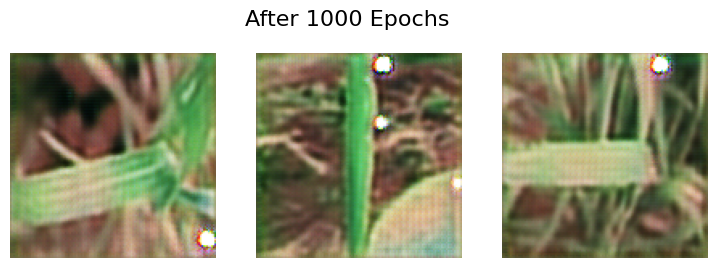

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

directory = "Stripe_Rust_1020"

# get all image file names and shuffle them
file_names = os.listdir(directory)
random.shuffle(file_names)

# create figure with 1 row and 4 columns
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# display the figure
# loop through first 4 images and plot them
for i in range(3):
    # read image
    img = mpimg.imread(os.path.join(directory, file_names[i]))

    # resize image
    img = cv2.resize(img, (128, 128))

    # plot image on corresponding axis
    axs[i].imshow(img)
    axs[i].axis('off')
    # axs[i].set_title("After 1000 Epochs")


fig.suptitle("After 1000 Epochs", fontsize=16)
plt.show()

In [ ]:
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_002040.h5', cust)
model_BtoA = load_model('/content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_002040.h5', cust)

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
import cv2
from tqdm import tqdm
import numpy as np
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img


# pathA = ["CropDisease/Crop___DIsease/Wheat___Brown_Rust/"]
pathA = ["/content/drive/My Drive/Wheat_Disease/wheat_leaf/Healthy/"]
c = 0

folder_name = "Stripe_Rust_2040"
if not os.path.isdir(folder_name):
  os.mkdir(folder_name)

for folder in tqdm(pathA):
  for img_in_folder in os.listdir(folder):
    test_image = load_img(folder+img_in_folder, target_size=(128, 128))
    test_image = img_to_array(test_image)
    test_image_input = np.array([test_image])
    test_image_input = (test_image_input - 127.5) / 127.5

    img_gen = model_AtoB.predict(test_image_input)
    image = vstack((img_gen))
    image = (image + 1) / 2.0
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"{folder_name}/stripe_rust_{c}_{img_in_folder}.png", image*255.)
    c+=1

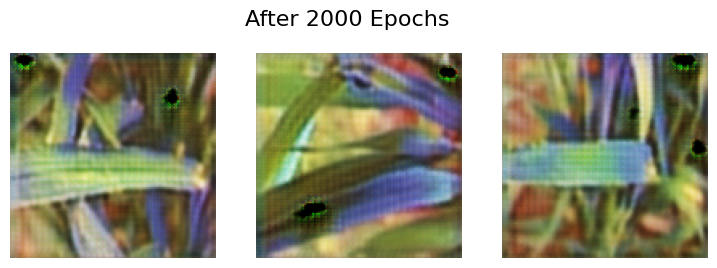

In [ ]:
plot_image_epoch("Stripe_Rust_2040", "After 2000 Epochs")

In [ ]:
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_AtoB_003060.h5', cust)
model_BtoA = load_model('/content/drive/My Drive/Wheat_Disease/Cyclegan_Wheat/Stripe_Rust/g_model_BtoA_003060.h5', cust)

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
pathA = ["/content/drive/My Drive/Wheat_Disease/wheat_leaf/Healthy/"]
c = 0

folder_name = "Stripe_Rust_3060"
if not os.path.isdir(folder_name):
  os.mkdir(folder_name)

for folder in tqdm(pathA):
  for img_in_folder in os.listdir(folder):
    test_image = load_img(folder+img_in_folder, target_size=(128, 128))
    test_image = img_to_array(test_image)
    test_image_input = np.array([test_image])
    test_image_input = (test_image_input - 127.5) / 127.5

    img_gen = model_AtoB.predict(test_image_input)
    image = vstack((img_gen))
    image = (image + 1) / 2.0
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"{folder_name}/stripe_rust_{c}_{img_in_folder}.png", image*255.)
    c+=1

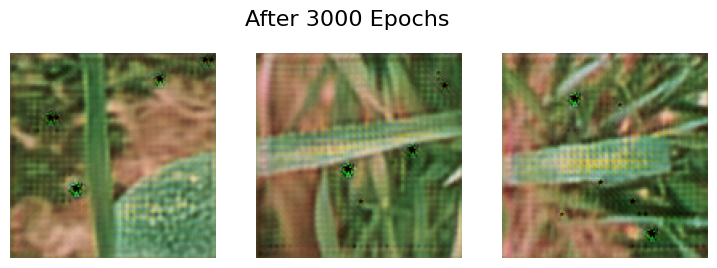

In [ ]:
plot_image_epoch("Stripe_Rust_3060", "After 3000 Epochs")